In [4]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

     -------------------------------------- 310.8/310.8 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285432 sha256=43362c186793a9ad5b831c3755ec21e5668c25270ff6d35124726909007fbcb2
  Stored in directory: c:\users\belka\appdata\local\pip\cache\wheels\53\fe\23\517784b9d9dadfb82c5676e76483422096aa5dc20d4d602213
Successfully built pyspark


In [28]:
df = spark.read.csv('PS_20174392719_1491204439457_log.csv',
                         sep=',',
                         header=True)

# View the first five records
df.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

TypeError: 'Column' object is not callable

In [6]:
num_rows = df.count()
num_columns = len(df.columns)
print(num_rows)
print(num_columns)

21095
11


In [7]:
from pyspark.sql.types import DoubleType

df = df.withColumn("step", df.step.cast(DoubleType()))
df = df.withColumn("amount", df.amount.cast(DoubleType()))
df = df.withColumn("oldbalanceOrg", df.oldbalanceOrg.cast(DoubleType()))
df = df.withColumn("newbalanceOrig", df.newbalanceOrig.cast(DoubleType()))
df = df.withColumn("oldbalanceDest", df.oldbalanceDest.cast(DoubleType()))
df = df.withColumn("newbalanceDest", df.newbalanceDest.cast(DoubleType()))
df = df.withColumn("isFraud", df.isFraud.cast('int'))

In [8]:
df = df.drop('isFlaggedFraud')


In [11]:
numeric_features = [ t[0] for t in df.dtypes if t[1] == 'bouble' or t[1] == 'int']

In [13]:
numeric_features

['isFraud']

In [14]:
df.dtypes

[('step', 'double'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int')]

In [18]:
import pandas as pd
pd_df = df.toPandas()
print('Distribution of the Classes in the dataset')
print(pd_df['isFraud'].value_counts()/len(pd_df))

Distribution of the Classes in the dataset
0    0.99616
1    0.00384
Name: isFraud, dtype: float64


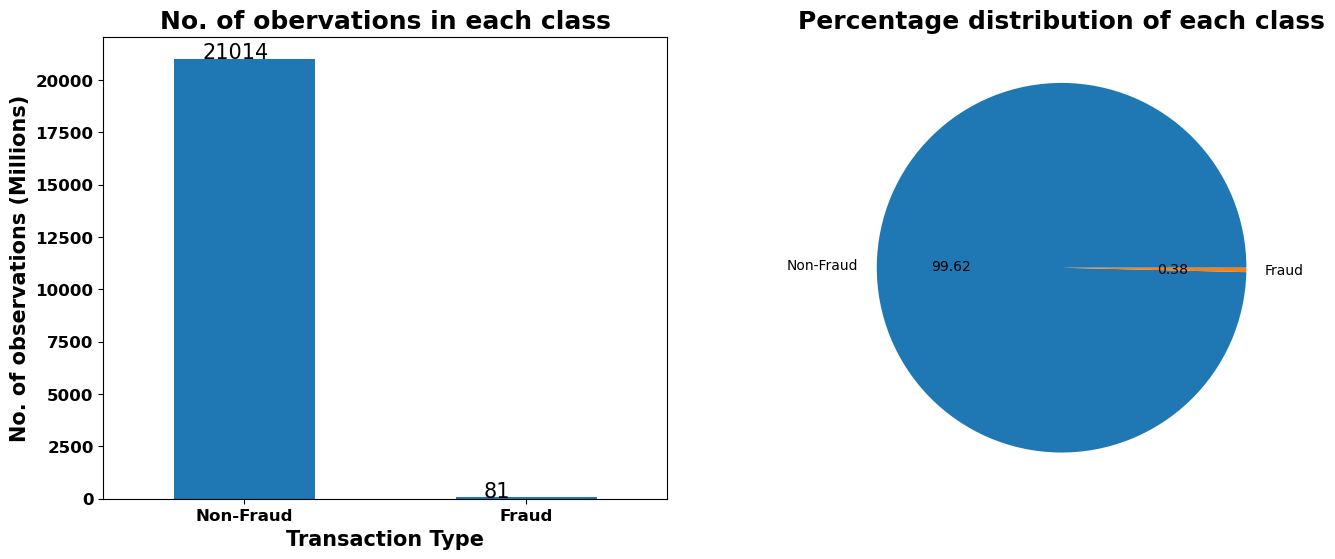

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.subplots(1,2, figsize=(16,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = pd_df['isFraud'].value_counts().plot(kind='bar')
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'], rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each class', fontsize=18, fontweight='bold')
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(pd_df['isFraud'].value_counts(), labels=['Non-Fraud','Fraud'], autopct='%.2f')
plt.title('Percentage distribution of each class', fontsize=18, fontweight='bold')

# display plot
plt.show()

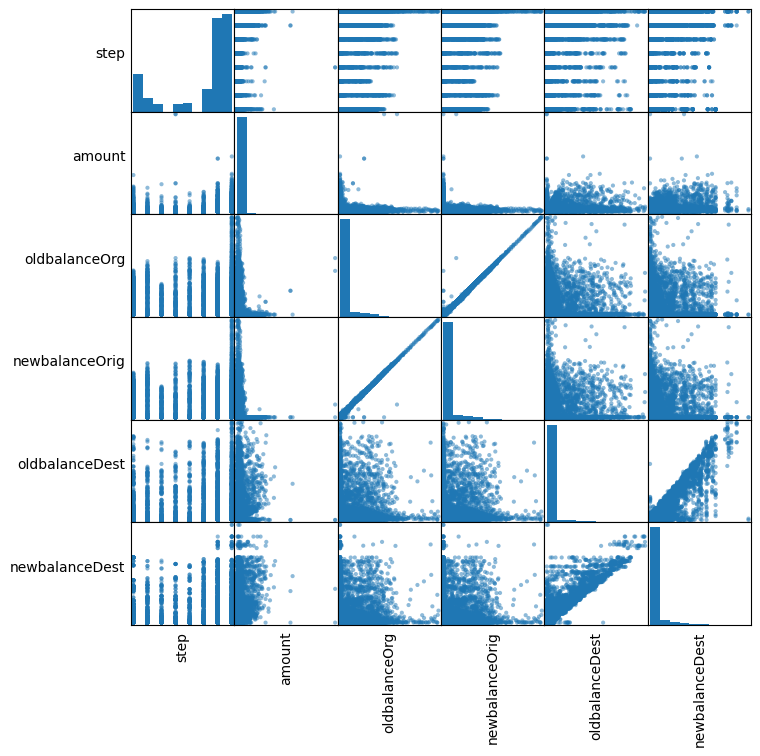

In [20]:
import pandas as pd
from pandas.plotting import scatter_matrix

numeric_features = ['step', 'amount', 'oldbalanceOrg',
                    'newbalanceOrig','oldbalanceDest', 
                    'newbalanceDest']

numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

C:\Users\belka\AppData\Local\Temp\ipykernel_12476\3998553983.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sub_sample_corr = pd_df.corr()


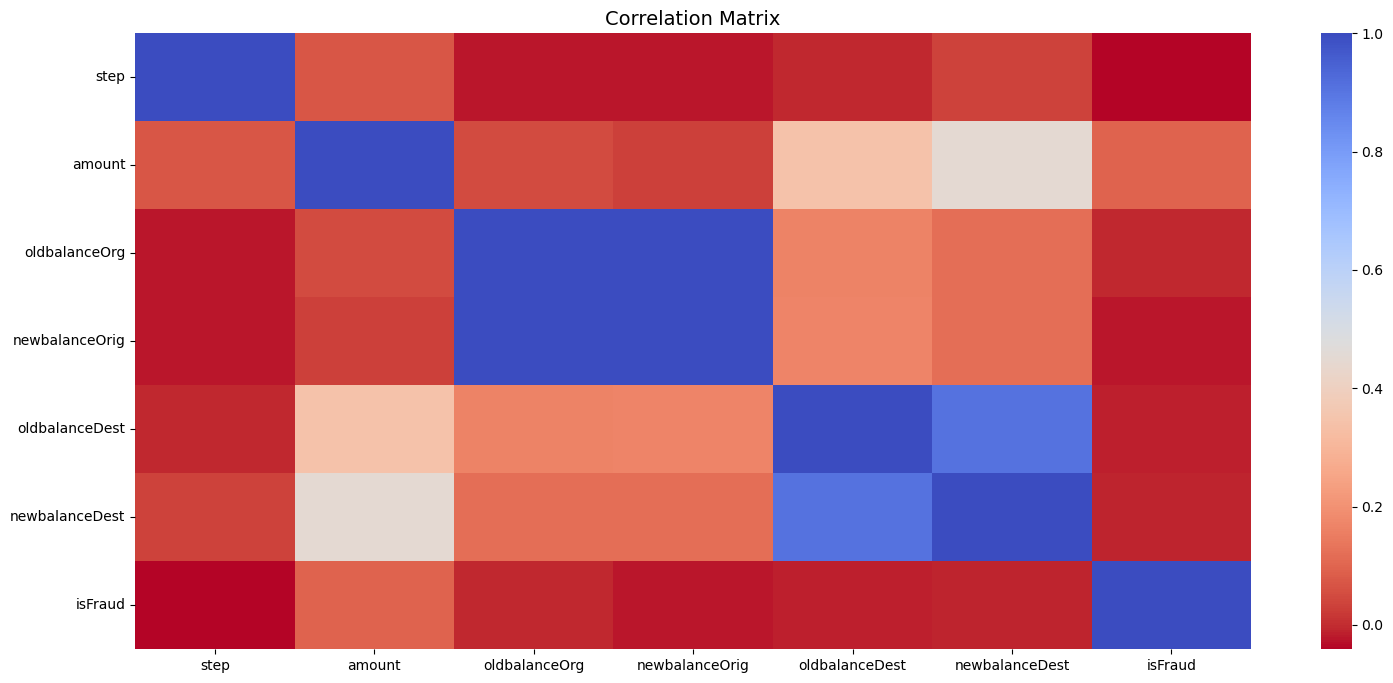

In [21]:
# we can check the important parameters that could effect our model.
f, ax = plt.subplots(figsize=(18,8))

sub_sample_corr = pd_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14)
plt.show()

In [22]:
import pandas as pd
data = pd.read_csv("PS_20174392719_1491204439451_log.csv")

In [23]:
data['nameOrig'] = data['nameOrig'].str.replace('C', '1', regex=True)
data['nameOrig'] = data['nameOrig'].str.replace('M', '0', regex=True)
data['nameDest'] = data['nameDest'].str.replace('C', '1', regex=True)
data['nameDest'] = data['nameDest'].str.replace('M', '0', regex=True)


In [24]:
data['nameOrig'] = data['nameOrig'].astype(float)
data['nameDest'] = data['nameDest'].astype(float)

In [31]:
data['step']

0            1
1            1
2            1
3            1
4            1
          ... 
1598102    743
1598103    743
1598104    743
1598105    743
1598106    743
Name: step, Length: 1598107, dtype: int64

In [25]:

data['type'] = data['type'].str.replace('PAYMENT', '0', regex=True)
data['type'] = data['type'].str.replace('TRANSFER', '1', regex=True)
data['type'] = data['type'].str.replace('CASH_OUT', '2', regex=True)
data['type'] = data['type'].str.replace('DEBIT', '3', regex=True)
data['type'] = data['type'].str.replace('CASH_IN', '4', regex=True)

data['type'] = data['type'].astype(int)

In [26]:
data.shape


(1598107, 11)

In [27]:
data.dtypes


step                int64
type                int32
amount            float64
nameOrig          float64
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
Y= data["isFraud"]

X= pd.DataFrame(data, columns=["step"	,"type",	"amount",	"nameOrig",	"oldbalanceOrg"	,"newbalanceOrig"	,"nameDest"	,"oldbalanceDest"	,"newbalanceDest"])


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [9]:
test_df = pd.DataFrame(X_test)
test_df['target'] = y_test


In [10]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train


In [11]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


Y= data["isFraud"]
X= pd.DataFrame(data, columns=["step"	,"type",	"amount",	"nameOrig",	"oldbalanceOrg"	,"newbalanceOrig"	,"nameDest"	,"oldbalanceDest"	,"newbalanceDest"])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

RFC = RandomForestClassifier()
RFC.fit(x_train, y_train)

y_pred = RFC.predict(x_test)
acc_RFC = round(accuracy_score(y_test, y_pred) * 100, 2)

#self.accuracy_label.setText(f"Accuracy Score: {acc_RFC}%")


In [12]:
print(acc_RFC)

99.97


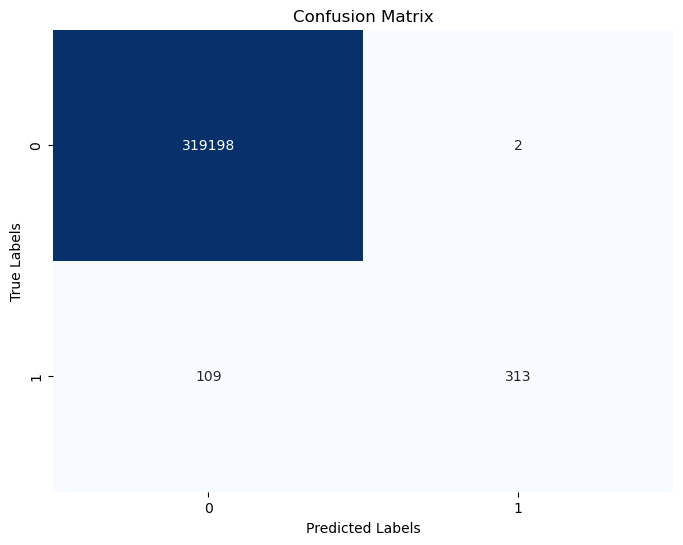

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have trained your model and obtained the predicted labels (y_pred) and true labels (y_true)
# y_pred and y_true should be NumPy arrays or lists

# Compute the confusion matrix
#y_true = data['isFraud']
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest classifier
rf = RandomForestClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)  # X_train and y_train are your training data

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rf_model is your trained Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

# Predict probabilities using the trained model
y_pred_prob = rf_model.predict_proba(x_test)[:, 1]

# Assign shades of color based on the probability of fraud
colors = y_pred_prob

# Plotting the transactions
plt.scatter(range(len(y_pred_prob)), y_pred_prob, c=colors, cmap='RdYlGn')
plt.xlabel('Transaction')
plt.ylabel('Probability')
plt.title('Fraud Detection Model Predictions')
plt.colorbar()
plt.show()
